In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout, Conv2D,MaxPool2D,ZeroPadding2D, GlobalAveragePooling2D, BatchNormalization, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import vgg16
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

#for model deployement 
import os
import numpy as np
from keras.models import model_from_json
from keras.utils import img_to_array

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/fer2013.csv') #read dataset

df.head(5)
#,df.shape

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [25]:
emotions = { #list of available emotions in the dataset
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprize",
    6:"Neutral"
}
count_emotions = (df.groupby(df['emotion'])['pixels'].count()).to_frame()
count_emotions['emotion name'] = [emotions[k] for k in emotions.keys()]
count_emotions

,pixels,emotion name
emotion,,
0,4953,Angry
1,547,Disgust
2,5121,Fear
3,8989,Happy
4,6077,Sad
5,4002,Surprize
6,6198,Neutral


In [4]:
def preprocess(input_data):

    input_images = np.zeros(shape=(input_data.shape[0], 48, 48))

    for i, row in enumerate(input_data.index):

        image = np.fromstring(input_data.loc[row, 'pixels'], dtype=int, sep=' ')

        image = np.reshape(image, (48, 48))

        input_images[i] = image

    input_images = input_images.reshape((input_images.shape[0], 48, 48, 1))

    input_images = input_images.astype('float32')/255

    input_labels = np.array(list(map(int, input_data['emotion'])))

    image_labels = to_categorical(input_labels, 7)

    return  input_images, image_labels

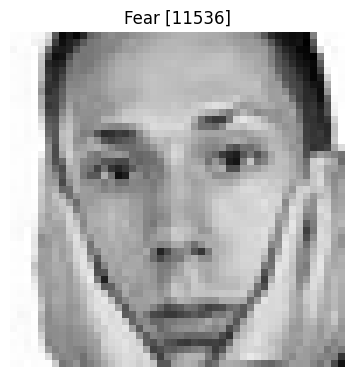

In [30]:
def visualize_images(n_img=4):
    indices = np.random.randint(0,df.shape[0],size=n_img)
#     print(indices)
    plt.figure(figsize=(20,20))
    for i,l in zip(indices,range(0,len(indices))):
        image_ar = np.array([i for i in  df['pixels'][i].split()] , dtype='float')
        pixels = np.reshape(image_ar,(48,48))
        ax = plt.subplot(4,4,l+1)
        plt.imshow(pixels,cmap='gray')
        plt.title(emotions[df['emotion'][i]]+" ["+str(i)+"]")
        plt.xticks()
        plt.yticks([])
        plt.axis("off")
visualize_images(1)

In [15]:
def fer_improved_cnn():

    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))

    model.add(BatchNormalization())

    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))

    model.add(BatchNormalization())

    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))

    model.add(BatchNormalization())

    model.add(Flatten())

    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu'))

    model.add(Dense(7, activation='softmax'))

    return model

In [ ]:
len(df)

35887

In [6]:
train_x, train_y = preprocess(df[:30000])

In [7]:
val_x, val_y = preprocess(df[30000:])

In [9]:
import keras
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and accuracy is {:7.2f}.".format(
                epoch, logs["loss"], logs["accuracy"]
            )
        )


In [ ]:
import math
batch_size=128
trainingsize = 30000 

def calculate_spe(y, batch_size):
  return int(math.ceil((1. * y) / batch_size)) 

stepsPerEpoch = calculate_spe(trainingsize, batch_size)
stepsPerEpoch

235

In [16]:
import keras
adam = keras.optimizers.Adam(learning_rate=0.00006)

model = fer_improved_cnn()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.00006),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
model.fit(train_x, train_y,
                    validation_data=(val_x, val_y),
                    epochs=120,
                    verbose=2,
                    callbacks=LossAndErrorPrintingCallback(),
                    steps_per_epoch = 235,
                    validation_freq=2,
                    batch_size=128)

Epoch 1/120
The average loss for epoch 0 is    2.18 and accuracy is    0.27.
235/235 - 136s - loss: 2.1767 - accuracy: 0.2669 - 136s/epoch - 580ms/step
Epoch 2/120
The average loss for epoch 1 is    1.83 and accuracy is    0.34.
235/235 - 143s - loss: 1.8257 - accuracy: 0.3360 - val_loss: 1.7156 - val_accuracy: 0.3098 - 143s/epoch - 609ms/step
Epoch 3/120
The average loss for epoch 2 is    1.70 and accuracy is    0.37.
235/235 - 132s - loss: 1.7040 - accuracy: 0.3692 - 132s/epoch - 561ms/step
Epoch 4/120
The average loss for epoch 3 is    1.63 and accuracy is    0.39.
235/235 - 143s - loss: 1.6254 - accuracy: 0.3935 - val_loss: 1.5075 - val_accuracy: 0.4248 - 143s/epoch - 607ms/step
Epoch 5/120
The average loss for epoch 4 is    1.56 and accuracy is    0.41.
235/235 - 132s - loss: 1.5634 - accuracy: 0.4125 - 132s/epoch - 564ms/step
Epoch 6/120
The average loss for epoch 5 is    1.51 and accuracy is    0.43.
235/235 - 143s - loss: 1.5073 - accuracy: 0.4289 - val_loss: 1.4368 - val_accur

In [19]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
frontal_cascade_path = '/content/drive/MyDrive/Colab Notebooks/data/haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(frontal_cascade_path)

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/darius.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.3, 5)


for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]

cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

In [18]:
model.save('new_model', save_format= "tf")

In [19]:
import tensorflow as tf
my_model = tf.keras.saving.load_model('new_model', compile=False)
probability_model = tf.keras.Sequential([my_model, tf.keras.layers.Softmax()])

In [22]:
preds = probability_model.predict(val_x)

184/184 [==============================] - 9s 45ms/step


In [23]:
preds[80]

array([0.15768978, 0.12288043, 0.15150513, 0.12315026, 0.15654092,
       0.1228821 , 0.16535138], dtype=float32)

In [52]:
from keras.preprocessing import image
import numpy as np
# Add the image to a batch where it's the only member., target_size=(48, 48)
#img = '/content/drive/MyDrive/Colab Notebooks/data/PrivateTest_1109992.jpg'
img = '/content/drive/MyDrive/Colab Notebooks/data/PrivateTest_10304478.jpg'
img = image.image_utils.load_img(img)
y = image.image_utils.img_to_array(img)
y = np.expand_dims(y, axis=0)
y = np.reshape(y, (-1, 48, 48, 1)) 

# pass the list of multiple images np.vstack()[:10]
# images = np.vstack([x, y])
classes = model.predict(y, verbose=0, batch_size=1)
predicted_label = np.argmax(classes, keepdims = True, axis = 0)
predicted_label

array([[0, 0, 0, 0, 1, 0, 1]])

In [53]:
image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Colab Notebooks/data/PrivateTest_1109992.jpg')
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.expand_dims(input_arr, axis=0)
input_arr = np.reshape(input_arr, (-1, 48, 48, 1)) 
predictions = probability_model.predict(input_arr, verbose = 0, batch_size = 1)
predictions

array([[0.1147015, 0.1147015, 0.1147015, 0.311791 , 0.1147015, 0.1147015,
        0.1147015],
       [0.1147015, 0.1147015, 0.1147015, 0.311791 , 0.1147015, 0.1147015,
        0.1147015],
       [0.1147015, 0.1147015, 0.1147015, 0.1147015, 0.311791 , 0.1147015,
        0.1147015]], dtype=float32)

In [55]:
predictions = np.argmax(predictions, keepdims = True, axis = 1)
predictions

array([[4]])